In [1]:
!python3 -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 465 kB/s            
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm

nlp = spacy.load('en_core_web_sm')

from spacy.tokens import Span
from spacy.matcher import Matcher

import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
import neptune.new as neptune

%matplotlib inline

In [ ]:
run = neptune.init(api_token="your API key",
                   project="aravindcr/KnowledgeGraphs")

In [3]:
data = pd.read_csv('capLabel_All.csv')
data.head()

,filename,caption
0,036166_29fba09e.jpg,a dog standing on the side of a dirt road
1,074DF9CDDC33B3B774722C27D2B8074854000304.jpg,a white and black animal standing on the side ...
2,082001_bcd90588.jpg,a herd of sheep walking down a dirt road
3,1129772_a671f2ff.jpg,a herd of sheep walking down a dirt road
4,131590_023e94c7.jpg,two sheep walking down a dirt road


In [4]:
data['caption'][10]

'a herd of sheep standing on top of a dirt road'

In [5]:
# Lets take part of the above extracted article
docu = nlp('''The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by 
the UK Rapid Test Consortium and manufactured by Abingdon Health. It uses a lateral flow test to determine 
whether a person has IgG antibodies to the SARS-CoV-2 virus that causes COVID-19. The test uses a single 
drop of blood obtained from a finger prick and yields results in 20 minutes.\n\nSee also\nCOVID-19 rapid 
antigen test''')

for tokn in docu:
    print(tokn.text, "---", tokn.dep_)

The --- det
AbC-19 --- nmod
rapid --- amod
antibody --- compound
test --- nsubj
is --- ROOT
an --- det
immunological --- amod
test --- attr
for --- prep
COVID-19 --- amod
exposure --- pobj
developed --- acl
by --- agent

 --- dep
the --- det
UK --- compound
Rapid --- compound
Test --- compound
Consortium --- pobj
and --- cc
manufactured --- conj
by --- agent
Abingdon --- compound
Health --- pobj
. --- punct
It --- nsubj
uses --- ROOT
a --- det
lateral --- amod
flow --- compound
test --- dobj
to --- aux
determine --- xcomp

 --- dep
whether --- mark
a --- det
person --- nsubj
has --- ccomp
IgG --- nsubj
antibodies --- dobj
to --- prep
the --- det
SARS --- compound
- --- punct
CoV-2 --- compound
virus --- pobj
that --- nsubj
causes --- relcl
COVID-19 --- dobj
. --- punct
The --- det
test --- nsubj
uses --- ROOT
a --- det
single --- amod

 --- dep
drop --- dobj
of --- prep
blood --- pobj
obtained --- acl
from --- prep
a --- det
finger --- compound
prick --- pobj
and --- cc
yields --- conj

In [6]:
def extract_entities(sents):
    # chunk one
    enti_one = ""
    enti_two = ""
    
    dep_prev_token = "" # dependency tag of previous token in sentence
    
    txt_prev_token = "" # previous token in sentence
    
    prefix = ""
    modifier = ""
    
    
    
    for tokn in nlp(sents):
        # chunk two
        ## move to next token if token is punctuation
        
        if tokn.dep_ != "punct":
            #  check if token is compound word or not
            if tokn.dep_ == "compound":
                prefix = tokn.text
                # add current word to it if prevoius word is 'compound
                if dep_prev_token == "compound":
                    prefix = txt_prev_token + " "+ tokn.text
                    
            # verify if token is modifier or not
            if tokn.dep_.endswith("mod") == True:
                modifier = tokn.text
                # add it to the current word if previous word is 'compound'
                if dep_prev_token == "compound":
                    modifier = txt_prev_token + " "+ tokn.text
                    
            # chunk3
            if tokn.dep_.find("subj") == True:
                enti_one = modifier +" "+ prefix + " "+ tokn.text
                prefix = ""
                modifier = ""
                dep_prev_token = ""
                txt_prev_token = ""
                
            # chunk4 
            if tokn.dep_.find("obj") == True:
                enti_two = modifier +" "+ prefix +" "+ tokn.text
                
            # chunk 5
            # update variable
            dep_prev_token = tokn.dep_
            txt_prev_token = tokn.text
            
    return [enti_one.strip(), enti_two.strip()]

In [7]:
extract_entities("The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test")

['rapid antibody test', 'COVID-19 UK Rapid Test']

In [9]:
pairs_of_entities = []

for i in tqdm(data['caption'][:100000]):
    pairs_of_entities.append(extract_entities(i))

100%|██████████| 11564/11564 [00:45<00:00, 255.89it/s]


In [10]:
pairs_of_entities

[['', 'dirt road'],
 ['', 'white  road'],
 ['', 'dirt road'],
 ['', 'dirt road'],
 ['', 'two dirt road'],
 ['', 'next  river'],
 ['', 'brown  road'],
 ['', 'white  road'],
 ['cars', 'road'],
 ['', 'covered  road'],
 ['', 'dirt road'],
 ['', 'dirt road'],
 ['bear', 'day'],
 ['', 'dirt field'],
 ['', 'green  field'],
 ['', 'road'],
 ['two  cows', 'next  road'],
 ['', 'grassy  fence'],
 ['', 'geese  road'],
 ['', 'road'],
 ['', 'road'],
 ['', 'grassy  area'],
 ['', 'road'],
 ['woman', 'dog'],
 ['', 'road'],
 ['', 'green  hillside'],
 ['', 'road'],
 ['', 'road'],
 ['', 'road'],
 ['', 'large dirt road'],
 ['', 'green sheep field'],
 ['', 'dirt road'],
 ['', 'green  field'],
 ['', 'road'],
 ['', 'dirt road'],
 ['sheep', 'road'],
 ['', 'next dirt fence'],
 ['', 'green sheep field'],
 ['', 'road'],
 ['', 'next  pond'],
 ['', 'next  other'],
 ['', 'green cattle hillside'],
 ['', 'green cattle hillside'],
 ['', 'street'],
 ['', 'red brick wall'],
 ['', 'road'],
 ['', 'road'],
 ['', 'next  road']

In [11]:
def obtain_relation(sent):
    
    doc = nlp(sent)
    
    matcher = Matcher(nlp.vocab)
    
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]
    
    #matcher.add("matching_1", None, pattern)
    matcher.add("matching_1", [pattern], on_match=None)
    
    matcher = matcher(doc)
    h = len(matcher) - 1
    
    span = doc[matcher[h][1]:matcher[h][2]]
    
    return (span.text)

In [12]:
relations = [obtain_relation(j) for j in tqdm(data['caption'][:11564])]

100%|██████████| 11564/11564 [00:48<00:00, 239.06it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

covered          2110
car               810
road              604
herd of           549
truck             468
parked on         416
man               388
hydrant           382
street            353
street with       342
fire hydrant      323
truck with        265
person            207
driving           193
road with         166
walking down      165
pile of           162
scene with        119
river             119
parked in         119
body of           117
parked            113
dog               102
cow                97
sign on            95
sheep              94
people             92
tree               91
photo of           75
sign               67
standing on        64
river with         64
street at          63
area with          63
tree in            58
train              55
cars               53
person on          51
stopped at         49
boat               47
driving down       43
building with      42
stream of          42
car with           38
motorcycle         37
flock of  

In [14]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

In [16]:
data_kgf

,source,target,edge
0,,dirt road,dog
1,,white road,animal
2,,dirt road,herd of
3,,dirt road,herd of
4,,two dirt road,sheep
...,...,...,...
11559,,next tree,car
11560,bus,road,parked on
11561,fire truck,next logs,parked
11562,,street light,scene with


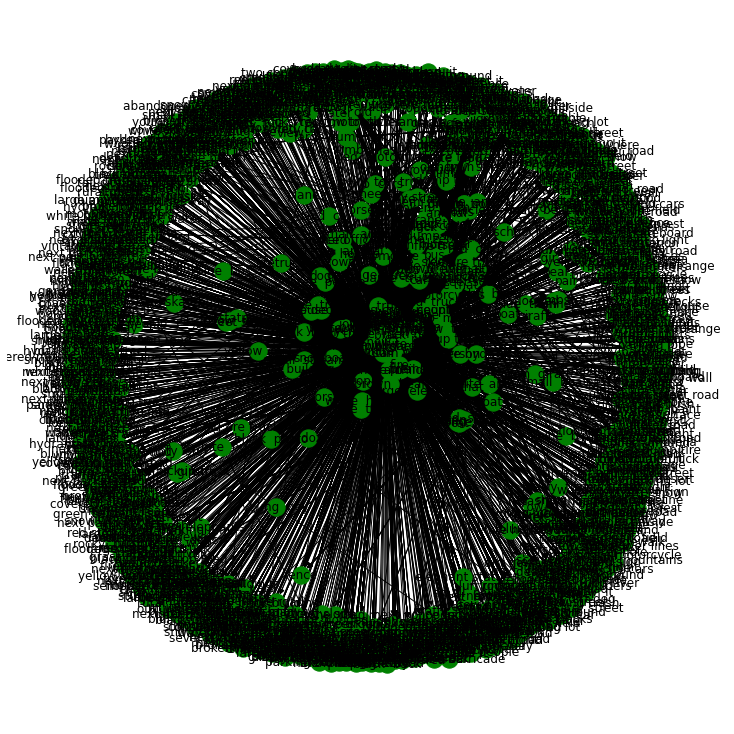

In [17]:
plot.figure(figsize=(10, 10))

posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

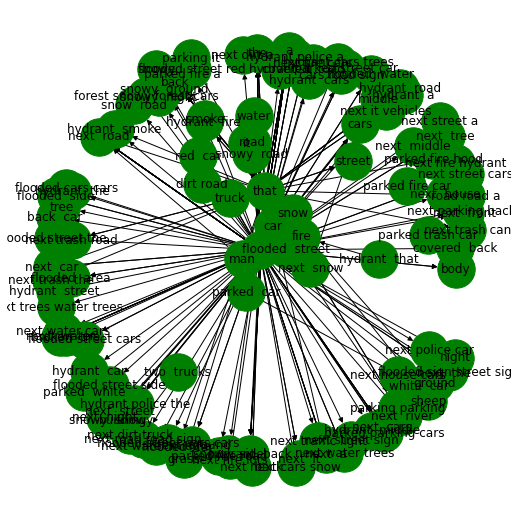

In [18]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="car"], "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(7,7))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [18]:
dataKG = pd.concat([data, data_kgf], axis=1)
dataKG

,filename,caption,source,target,edge
0,036166_29fba09e.jpg,a dog standing on the side of a dirt road,,dirt road,dog
1,074DF9CDDC33B3B774722C27D2B8074854000304.jpg,a white and black animal standing on the side ...,,white road,animal
2,082001_bcd90588.jpg,a herd of sheep walking down a dirt road,,dirt road,herd of
3,1129772_a671f2ff.jpg,a herd of sheep walking down a dirt road,,dirt road,herd of
4,131590_023e94c7.jpg,two sheep walking down a dirt road,,two dirt road,sheep
...,...,...,...,...,...
11559,X40vYG4ISI.jpg,a car parked on the side of a road next to a tree,,next tree,car
11560,XZGwySqE0h.jpg,a bus is parked on the side of the road,bus,road,parked on
11561,YJR1eMotsT.jpg,a fire truck is parked next to a pile of logs,fire truck,next logs,parked
11562,zlkcsgEw1e.jpg,a street scene with focus on a street light,,street light,scene with


In [19]:
concats = []
for s,t,e in zip(dataKG["source"], dataKG["target"], dataKG["edge"]):
    concat = s + ' ' + t + ' ' + e
    concats.append(concat) 

dataKG["concat"] = concats
dataKG

,filename,caption,source,target,edge,concat
0,036166_29fba09e.jpg,a dog standing on the side of a dirt road,,dirt road,dog,dirt road dog
1,074DF9CDDC33B3B774722C27D2B8074854000304.jpg,a white and black animal standing on the side ...,,white road,animal,white road animal
2,082001_bcd90588.jpg,a herd of sheep walking down a dirt road,,dirt road,herd of,dirt road herd of
3,1129772_a671f2ff.jpg,a herd of sheep walking down a dirt road,,dirt road,herd of,dirt road herd of
4,131590_023e94c7.jpg,two sheep walking down a dirt road,,two dirt road,sheep,two dirt road sheep
...,...,...,...,...,...,...
11559,X40vYG4ISI.jpg,a car parked on the side of a road next to a tree,,next tree,car,next tree car
11560,XZGwySqE0h.jpg,a bus is parked on the side of the road,bus,road,parked on,bus road parked on
11561,YJR1eMotsT.jpg,a fire truck is parked next to a pile of logs,fire truck,next logs,parked,fire truck next logs parked
11562,zlkcsgEw1e.jpg,a street scene with focus on a street light,,street light,scene with,street light scene with


In [20]:
dataKG.to_csv("capLabel_All_KG.csv", index=False)